## RealNVP Example

**Note as of 20/10/2020** This notebook works with TFP 0.8 but it is assumned that it will change due to expected changes in the API of TFP.

This notebook shows how to wrap learnable flows into Keras **subclassing** `tf.keras.models.Model`. 

In [44]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(1)
tf.random.set_seed(1)

TFP Version 0.8.0
TF  Version 2.0.0


### Learning Flows with TF 2.0

Let's create a flow using parameters, which can be learned. We use masked Autoregressive flows for that. 

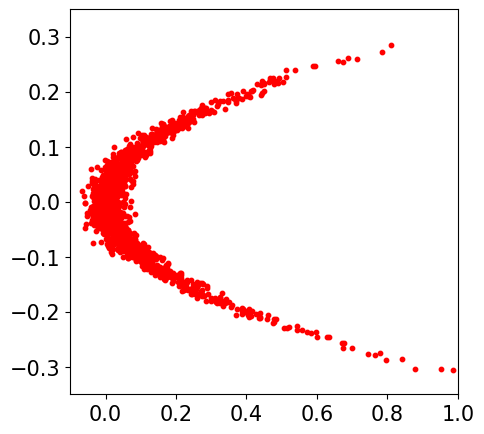

In [46]:
def sample(num):
    return np.array(np.random.uniform(-1,1,(num,2)), dtype='float32') #A real hard problem

# Adapted from: https://blog.evjang.com/2018/01/nf1.html
def sample_2(batch_size=500):
    x2_dist = tfd.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample(batch_size)
    x1 = tfd.Normal(loc=.25 * tf.square(x2_samples),
                    scale=tf.ones(batch_size, dtype=tf.float32))
    x1_samples = x1.sample()
    x_samples = tf.stack([x1_samples, x2_samples], axis=1)
    return x_samples.numpy()/40.0


X = sample_2(1500)


plt.figure(figsize=(5,5))
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.show()

### Makeing a Keras model

#### Subclassing a Keras model
We build our own model. As suggested in: https://www.tensorflow.org/beta/tutorials/quickstart/advanced we wrap the model into a Keras model class, by subclassing `tf.keras.models.Model`.


**Sometimes you start with Inf or NaN, run code serveral times?**

In [47]:
# See also https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

class RealNVP(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        # We need to keep track of the nets
        self.nets = []
        
        # Defining the bijector
        bijectors=[] #A
      
        h = 32
        for i in range(5): #B
            net = tfb.real_nvp_default_template(hidden_layers=[h, h])#C
            bijectors.append(tfb.RealNVP(shift_and_log_scale_fn=net,num_masked=num_masked))#D
            bijectors.append(tfb.Permute([1,0])) #E
            self.nets.append(net) 
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        self.flow = tfd.TransformedDistribution(#F
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]), 
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)
    

model = RealNVP(output_dim=2, num_masked=1)
### Below is a bit magic stuff, concerning eager execution
#model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
print(model.summary())


#A List of bijectors
#B Stacking of 5 layers
#C Definition of the Network
#D A shift and flow with parameters from the network
#E Permutation of coordinates
#F Distribution using z with two independent Gaussians

Model: "real_nvp_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 5,930
Trainable params: 5,930
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
##### Important
#Needs to be called other-wise @tf.function has problem
-tf.reduce_mean(model.flow.log_prob(X)) 

@tf.function #Adding the tf.function makes it about 10-50 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

from time import time
start = time()
for i in range(1001):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 100 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   1.85814 1.8612313270568848
100   -2.3713262 0.6440353393554688
200   -3.1256006 0.6531472206115723
300   -3.141074 0.6360969543457031
400   -3.1627984 0.6523547172546387
500   -3.161898 0.6715292930603027
600   -3.1688569 0.719496488571167
700   -3.1702569 0.756227970123291
800   -3.1610577 0.7785134315490723
900   -3.1610556 0.7222697734832764
1000   -3.1709516 0.6443688869476318


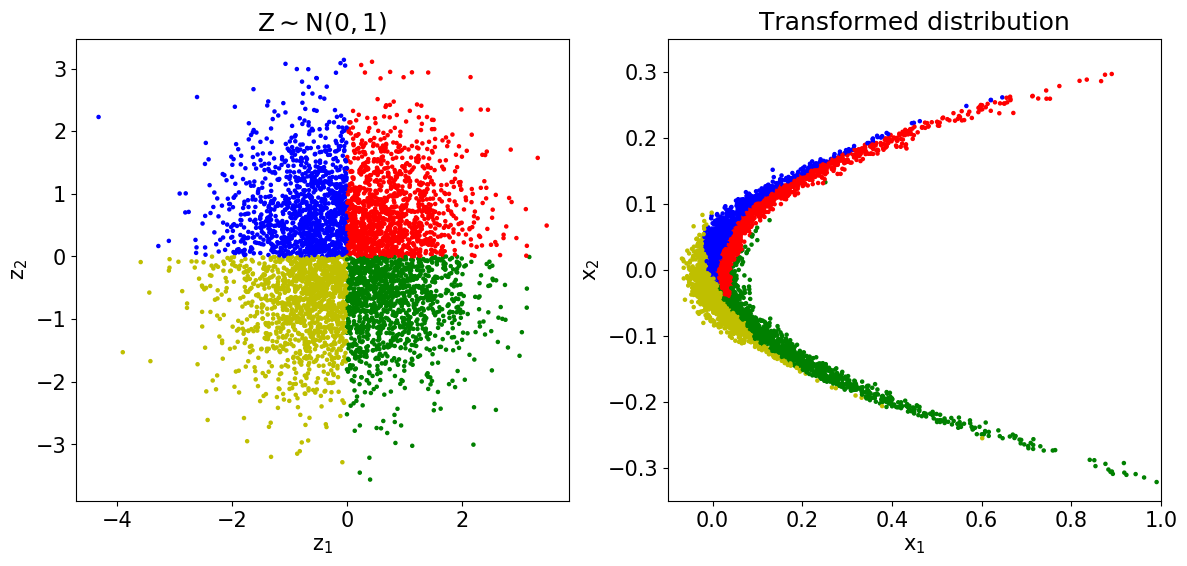

In [56]:
#XF = model.flow.sample(5000)
Z = np.random.normal(0,1,(5000,2))
cols = []
for i in range(5000):
    if (Z[i,0] > 0 and Z[i,1] > 0):
        cols.append('r')
    elif (Z[i,0] < 0 and Z[i,1] > 0):
        cols.append('b')
    elif (Z[i,0] < 0 and Z[i,1] < 0):
        cols.append('y')
    else:
        cols.append('g')

plt.figure(figsize=(14,6))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

plt.subplot(1,2,1)
plt.scatter(Z[:, 0], Z[:, 1], s=5,c=cols)
plt.title('$Z \sim N(0,1)$')
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
Xs = model(Z)

plt.subplot(1,2,2)
plt.title('Transformed distribution')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.scatter(Xs[:,0], Xs[:, 1], s=5, c=cols)
plt.xlim(-0.1,1)
plt.ylim(-0.35,0.35)
plt.savefig('ch06_realnvp.pdf')